In [1]:
!pip -q install kagglehub scikit-learn scipy statsmodels matplotlib torch

In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro, probplot
from statsmodels.stats.stattools import durbin_watson
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import kagglehub
from kagglehub import KaggleDatasetAdapter

In [3]:
file_name = "Airplane_Crashes_and_Fatalities_Since_1908_t0_2023.csv"

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "nayansubedi1/airplane-crashes-and-fatalities-upto-2023",
    file_name,
    pandas_kwargs={"encoding": "cp1252"}
)

df.head()

100%|██████████| 624k/624k [00:00<00:00, 1.05MB/s]

Extracting zip of Airplane_Crashes_and_Fatalities_Since_1908_t0_2023.csv...


,Date,Time,Location,Operator,Flight #,Route,AC Type,Registration,cn/ln,Aboard,Aboard Passangers,Aboard Crew,Fatalities,Fatalities Passangers,Fatalities Crew,Ground,Summary
0,9/17/1908,17:18,"Fort Myer, Virginia",Military - U.S. Army,NaN,Demonstration,Wright Flyer III,NaN,1,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During a demonstration flight, a U.S. Army fly..."
1,9/7/1909,NaN,"Juvisy-sur-Orge, France",NaN,NaN,Air show,Wright Byplane,SC1,NaN,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre was the first pilot to ever be...
2,7/12/1912,6:30,"Atlantic City, New Jersey",Military - U.S. Navy,NaN,Test flight,Dirigible,NaN,NaN,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. dirigible Akron exploded just offsh...
3,8/6/1913,NaN,"Victoria, British Columbia, Canada",Private,NaN,NaN,Curtiss seaplane,NaN,NaN,1.0,0.0,1.0,1.0,0.0,1.0,0.0,The first fatal airplane accident in Canada oc...
4,9/9/1913,18:30,Over the North Sea,Military - German Navy,NaN,NaN,Zeppelin L-1 (airship),NaN,NaN,20.0,NaN,NaN,14.0,NaN,NaN,0.0,The airship flew into a thunderstorm and encou...


## 1. Przygotowanie danych

In [4]:
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

df["date"] = pd.to_datetime(df["date"], errors="coerce")
for c in ["aboard", "fatalities", "ground"]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

feature_cols = ["aboard", "ground", "year", "month"]
target_col = "fatalities"

df_model = df[feature_cols + [target_col, "date"]].copy()
df_model = df_model.dropna(subset=[target_col])

df_model.isna().sum()

,0
aboard,10
ground,34
year,0
month,0
fatalities,0
date,0


##2. Podział na zbiór treningowy i testowy

In [5]:
X = df_model[feature_cols]
y = df_model[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape

((3992, 4), (998, 4))

##3. Modele klasyczne


In [6]:
models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1, max_iter=10000)
}

def eval_metrics(y_true, y_pred):
    return {
        "R²": r2_score(y_true, y_pred),
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
    }

results = {}
for name, model in models.items():
    pipe = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    results[name] = {
        "model": pipe,
        "y_pred": y_pred,
        **eval_metrics(y_test, y_pred)
    }

pd.DataFrame({k: {m: v[m] for m in ["R²","MSE","MAE"]} for k,v in results.items()}).T

,R²,MSE,MAE
Linear,0.614618,393.962130,9.999342
Ridge,0.614618,393.962141,9.999342
Lasso,0.614644,393.936262,9.998737


##4. Porównanie skali danych (oryginalne vs znormalizowane)

In [7]:
ridge_raw = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", Ridge(alpha=1.0))
])

ridge_scaled = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("model", Ridge(alpha=1.0))
])

ridge_raw.fit(X_train, y_train)
ridge_scaled.fit(X_train, y_train)

pred_raw = ridge_raw.predict(X_test)
pred_scaled = ridge_scaled.predict(X_test)

compare_scale = pd.DataFrame({
    "Ridge(raw)": eval_metrics(y_test, pred_raw),
    "Ridge(scaled)": eval_metrics(y_test, pred_scaled)
}).T

compare_scale

,R²,MSE,MAE
Ridge(raw),0.614618,393.962141,9.999342
Ridge(scaled),0.614576,394.005661,10.001065


##5. Wizualizacja dopasowania (dla jednej cechy)

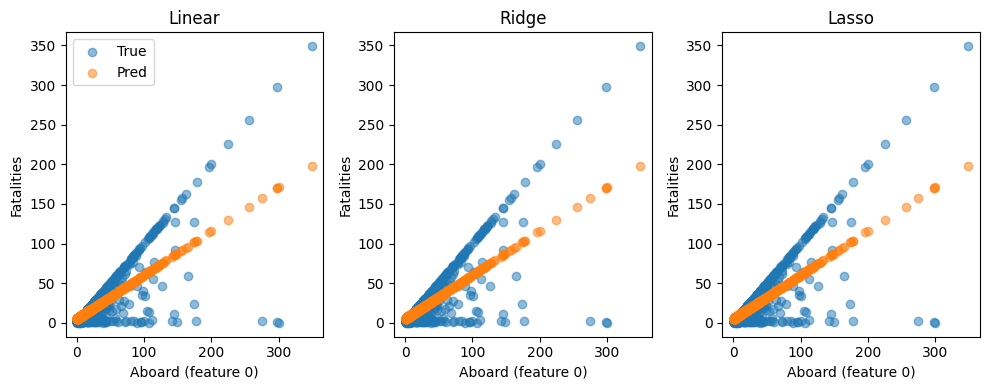

In [8]:
x_feat = X_test.iloc[:, 0].values
y_true = y_test.values

plt.figure(figsize=(10, 4))
for i, (name, res) in enumerate(results.items()):
    plt.subplot(1, 3, i+1)
    plt.scatter(x_feat, y_true, alpha=0.5, label="True")
    plt.scatter(x_feat, res["y_pred"], alpha=0.5, label="Pred")
    plt.title(name)
    plt.xlabel("Aboard (feature 0)")
    plt.ylabel("Fatalities")
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

##6. Wpływ zmiennych objaśniających (ważność cech w Ridge)

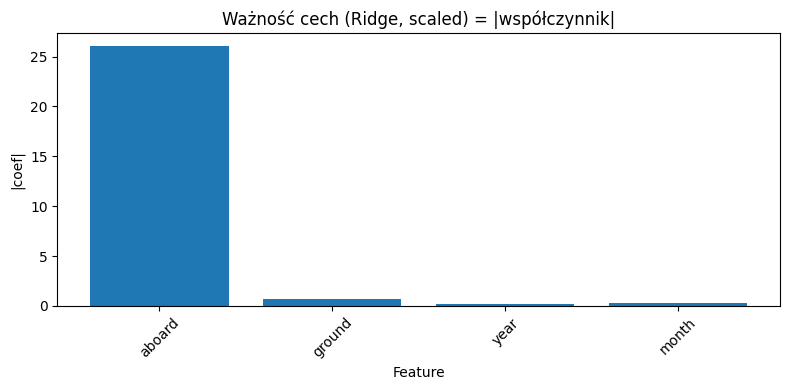

array([26.08037874,  0.6857094 ,  0.23939799,  0.33836059])

In [9]:
ridge_model = ridge_scaled.named_steps["model"]
feature_importance = np.abs(ridge_model.coef_)

plt.figure(figsize=(8, 4))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xticks(range(len(feature_importance)), feature_cols, rotation=45)
plt.xlabel("Feature")
plt.ylabel("|coef|")
plt.title("Ważność cech (Ridge, scaled) = |współczynnik|")
plt.tight_layout()
plt.show()

feature_importance

##7. Analiza reszt (regresja liniowa)

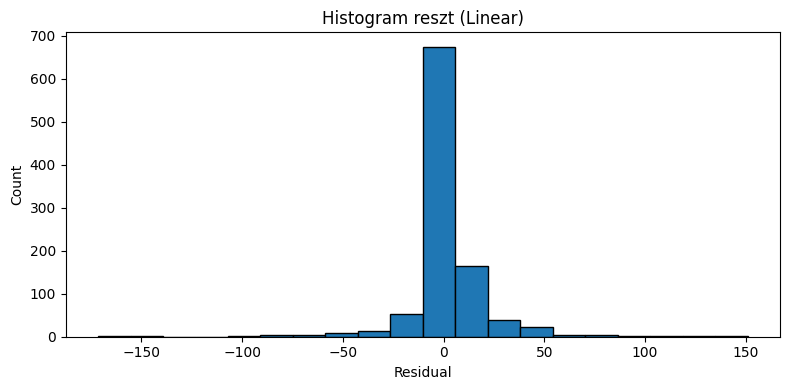

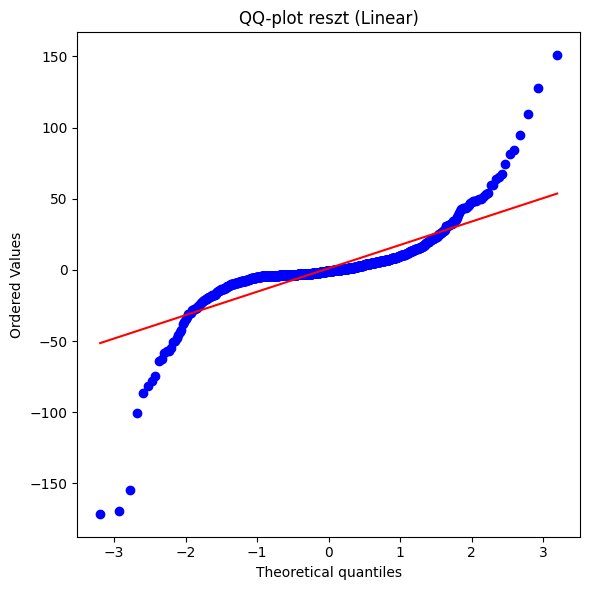

Shapiro-Wilk stat: 0.6898500523760411 p-value: 2.7760484324420335e-39
Durbin–Watson: 1.9750094971519956


In [10]:
linear_pipe = results["Linear"]["model"]
residuals = y_test - linear_pipe.predict(X_test)

plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=20, edgecolor="black")
plt.title("Histogram reszt (Linear)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 6))
probplot(residuals, dist="norm", plot=plt)
plt.title("QQ-plot reszt (Linear)")
plt.tight_layout()
plt.show()

sample = residuals.sample(min(len(residuals), 5000), random_state=42)
stat, p = shapiro(sample)
print("Shapiro-Wilk stat:", stat, "p-value:", p)

tmp = df_model.loc[X_test.index, ["date"]].copy()
tmp["resid"] = residuals.values
tmp = tmp.sort_values("date")
dw = durbin_watson(tmp["resid"].dropna().values)
print("Durbin–Watson:", dw)

##8. Sieć neuronowa

Epoch 20/200, Train Loss: 0.4737, Val Loss: 0.4751
Epoch 40/200, Train Loss: 0.4346, Val Loss: 0.4636
Epoch 60/200, Train Loss: 0.3991, Val Loss: 0.5082
Epoch 80/200, Train Loss: 0.3911, Val Loss: 0.5194
Epoch 100/200, Train Loss: 0.3580, Val Loss: 0.5102
Epoch 120/200, Train Loss: 0.3843, Val Loss: 0.5099
Epoch 140/200, Train Loss: 0.3527, Val Loss: 0.4949
Epoch 160/200, Train Loss: 0.3309, Val Loss: 0.5013
Epoch 180/200, Train Loss: 0.3296, Val Loss: 0.5658
Epoch 200/200, Train Loss: 0.3272, Val Loss: 0.5548


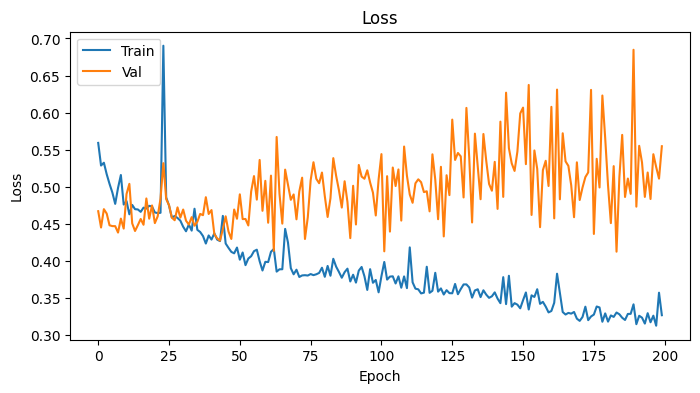

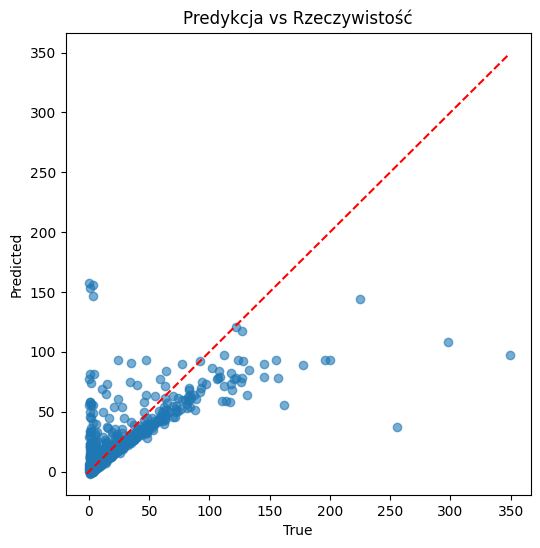

Sieć neuronowa MAE: 9.240585985554304
NN metrics: {'R²': 0.5289842766983424, 'MSE': 481.5027616139331, 'MAE': 9.240585985554304}


,R²,MSE,MAE
Linear,0.614618,393.962130,9.999342
Ridge,0.614618,393.962141,9.999342
NN,0.528984,481.502762,9.240586


In [11]:
imp = SimpleImputer(strategy="median")
X_train_imp = imp.fit_transform(X_train)
X_test_imp  = imp.transform(X_test)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_sc = scaler_X.fit_transform(X_train_imp)
X_test_sc  = scaler_X.transform(X_test_imp)

y_train_sc = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_sc  = scaler_y.transform(y_test.values.reshape(-1, 1))

Xtr = torch.tensor(X_train_sc, dtype=torch.float32)
ytr = torch.tensor(y_train_sc, dtype=torch.float32)
Xte = torch.tensor(X_test_sc, dtype=torch.float32)

class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

torch.manual_seed(42)
model_nn = RegressionNN(Xtr.shape[1])

criterion = nn.MSELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.01)

idx = np.arange(len(Xtr))
idx_tr, idx_val = train_test_split(idx, test_size=0.2, random_state=42)

Xtr_sub, ytr_sub = Xtr[idx_tr], ytr[idx_tr]
Xval_sub, yval_sub = Xtr[idx_val], ytr[idx_val]

batch_size = 32
train_loader = DataLoader(TensorDataset(Xtr_sub, ytr_sub), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xval_sub, yval_sub), batch_size=batch_size, shuffle=False)

epochs = 200
train_losses, val_losses = [], []

for epoch in range(epochs):
    model_nn.train()
    train_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        out = model_nn(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    model_nn.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            out = model_nn(xb)
            loss = criterion(out, yb)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

model_nn.eval()
with torch.no_grad():
    pred_test_sc = model_nn(Xte).numpy()

pred_test = scaler_y.inverse_transform(pred_test_sc).ravel()

plt.figure(figsize=(6,6))
plt.scatter(y_test, pred_test, alpha=0.6)
mn = min(y_test.min(), pred_test.min())
mx = max(y_test.max(), pred_test.max())
plt.plot([mn, mx], [mn, mx], "r--")
plt.title("Predykcja vs Rzeczywistość")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

print("Sieć neuronowa MAE:", mean_absolute_error(y_test, pred_test))

nn_metrics = {
    "R²": r2_score(y_test, pred_test),
    "MSE": mean_squared_error(y_test, pred_test),
    "MAE": mean_absolute_error(y_test, pred_test),
}
print("NN metrics:", nn_metrics)

summary_py = pd.DataFrame({
    "Linear": {k: results["Linear"][k] for k in ["R²","MSE","MAE"]},
    "Ridge":  {k: results["Ridge"][k]  for k in ["R²","MSE","MAE"]},
    "NN":     nn_metrics
}).T

summary_py

##9. Pojęcia: batch size / epoka / iteracja

In [12]:
n_samples = len(X_train)
iterations_per_epoch = math.ceil(n_samples / batch_size)

print("=== BATCH SIZE, EPOKA, ITERACJA ===")
print(f"Próbek: {n_samples}, Batch: {batch_size}, Epok: {epochs}")
print(f"Iteracji/epoka: {iterations_per_epoch}")
print(f"Łącznie iteracji: {iterations_per_epoch * epochs}")

=== BATCH SIZE, EPOKA, ITERACJA ===
Próbek: 3992, Batch: 32, Epok: 200
Iteracji/epoka: 125
Łącznie iteracji: 25000
